# Projet 5: Segmentez les comportements clients - Segmentation client

## Introduction

Nous avons dans une précédente partie analyser un dataset caractérisant les achats d'utilisateurs sur un site. Après une analyse exploratoire, nous avons essayer de créer une table qui permette selon nous de classer les utilisateurs selon des critères pertinents mais également pour que l'algorithme que nous allons implémenter dans cette partie converge rapidement.

## Kmeans

Nous choisissons tout d'abord d'utiliser un algotithme de kmeans puisque celui-ci va nous permettre de différencier les différents utlisateurs pour un coup de calcul pas très élevé. Nous allons donc utliser cette algorithme. Pour cela, il nous faut scaler nos données et ensuite trouver le nombre de classe optimum pour cette classification. 

Nous allons utiliser un StandardScaler (et ce malgré la présence d'outliers dans nos données) et observer les résultats grace à la méthode dit "du coude" ("elbow method" en anglais). Cette une méthode qui s'intéresse à la mesure de la somme des distances inter cluster et qui cherche à la minimser de manière intelligente.


On charge notre table.

In [1]:
import pandas as pd
df = pd.read_csv('data.csv')
data = df.drop('CustomerID', 1)

On normalise nos données avec un StandardScaler

In [2]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_normalized = sc.fit_transform(data)

On enregistre la somme des distances interclusters et le coefficient de silhouette

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
wcss = []
score = []
for i in range(2, 30, 1):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(data_normalized)
    wcss.append(kmeans.inertia_)
    score.append(silhouette_score(data_normalized, kmeans.predict(data_normalized)))

On regarde la somme des distances interclusters en fonction du nombre de clusters pour définir le nombre de clusters optimal.

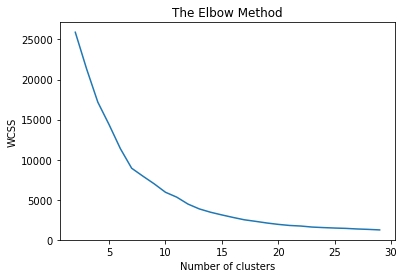

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(2, 30, 1), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

On voit clairement un coude se former sur notre graphique ce qui est une bonne nouvelle. On va pouvoir déterminer un nombre optimal de clusters. On décide de prendre un nombre de clusters égale à 10.

Regardons le coefficient de silhouette pour k=10.

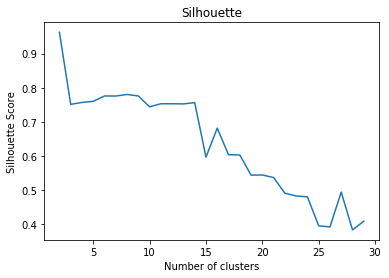

In [5]:
plt.plot(range(2, 30, 1), score)
plt.title('Silhouette')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [6]:
score[7]

0.77588121752072958

On va donc choisir un nombre de clusters égal à10.

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(data_normalized)

On va essayer d'observer la distribution de nos clusters pour essayer de créer les clusters les plus homogènes possibles.

In [9]:
import numpy as np
for i in np.unique(y_kmeans):
    c = sum(y_kmeans == i)
    print(c)

185
417
1
1
2
1
6
16
3738
4


On voit 3 clusters apparaitre en majorité. Nous allons avoir besoin de plus de clusters pour mieux différencié les différents utilisateurs.

In [14]:
kmeans = KMeans(n_clusters = 30, init = 'k-means++')
y_kmeans = kmeans.fit_predict(data_normalized)

In [15]:
import numpy as np
for i in np.unique(y_kmeans):
    c = sum(y_kmeans == i)
    print(c)

1224
413
1
1
2
3
1
1
2
1
101
62
2
3
25
11
1
216
3
12
371
1
1872
3
9
4
1
6
18
1


On voit 6 clusters se former en majorité. Nous allons maintenant assigner tous les utilisateurs appartenant à des petites classes aux clusters des grandes classes en regardant quel est le centroïde le plus proche.

In [32]:
import numpy as np
cluster_centers = kmeans.cluster_centers_
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')
list_indice = []
for i in np.unique(y_kmeans):
    if sum(y_kmeans == i)/len(y_kmeans) < 0.02:
        list_indice.append(i)
        
y_kmeans_small_class = np.unique(y_kmeans)[np.in1d(np.unique(y_kmeans), list_indice)]
y_kmeans_class = np.unique(y_kmeans)[~np.in1d(np.unique(y_kmeans), list_indice)]
cluster_centers = cluster_centers[y_kmeans_class]
for i in y_kmeans_small_class:
        d = data[y_kmeans == i]
        d_normalized = sc.fit_transform(d.values)
        for index in range(0, len(d_normalized)):
            row_normalized = d_normalized[index]
            x = np.concatenate([np.array(row_normalized).reshape((len(row_normalized), 1)).transpose(), cluster_centers], axis = 0)
            distance = dist.pairwise(x)[0,:]
            c = y_kmeans_class[np.argmin(distance[1:len(distance)])]
            y_kmeans[y_kmeans == i] = c

On peut maintenant que nos 6 classes sont formés regarder la distribution de ces classes.

([<matplotlib.patches.Wedge at 0x1659fbd39b0>,
  <matplotlib.text.Text at 0x1659fd70c50>])

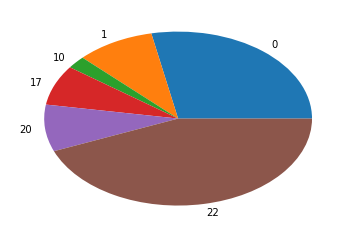

In [33]:
counts = []
for i in np.unique(y_kmeans):
    counts.append(sum(y_kmeans == i)/len(y_kmeans))
labels = y_kmeans_class
plt.pie(counts, labels = labels)

On peut maintenant essayer de regarder les caractéristiques de chacun de ces clusters en observant les caractéristiques de chacun des centroïdes.

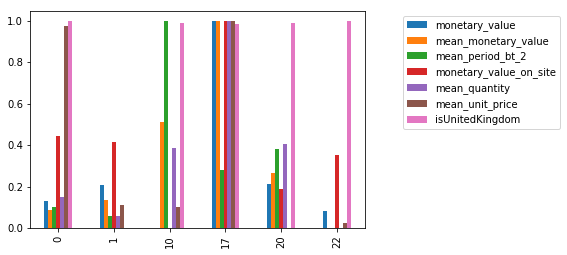

In [35]:
from sklearn.preprocessing import MinMaxScaler
cluster_centers = []
for i in np.unique(y_kmeans):
    cluster_centers.append(data[y_kmeans == i].mean().values)
cluster_centers = np.array(cluster_centers)
mm_sc = MinMaxScaler()
cluster_centers = mm_sc.fit_transform(cluster_centers)
center = pd.DataFrame(cluster_centers, index = y_kmeans_class, columns = data.columns)
ax = center.plot.bar();
ax.legend(bbox_to_anchor=(1.1, 1))

Nous pouvons dès à présent identifier qui sont les différents utilisateurs de notre dataset:

- la classe 0: cette utilisateur achète des articles à prix élevé en quantité moyenne, il revient assez souvent mais n'a pas encore dépensé énormément d'argent sur le site.
- la classe 1: correspond à la classe des utilisateurs étrangers, ces utilisateurs sont les moins actifs sur notre site.
- la classe 10: ces utilisateurs sont caractérisés par le fait qu'ils reviennent peu souvent sur notre site. Ils ont déjà dépensé de l'argent sur notre site sur des items à bas prix en quantité faible.
- la classe 17: représente les utilisateurs les plus actifs de notre site. Ils dépensent en grande quantité sur des items avec des prix élevés et reviennent régulièrement.
- la classe 20: ils reviennent souvent sur le site dépense de l'argent en petite quantité, et sont préents sur notre site depuis un moment.
- la classe 5: ils dépensent de manière plus conservatrices, reviennent assez souvent sans pour autant dépenser beaucoup d'argent (prix des items faibles).
- la classe 22: la classe des utilisateurs les moins présents sur le site.

Nous avons observé les différentes caractéristiques de nos classes. On veut maintenant pouvoir les classer le plus rapidement possible.

## Classification

Nous allons maintenant essayer de classsifier nos utilisateurs en entrainant notre algorithme sur nos données et essayer de retrouver les résultats de la classification précédente.

Tout d'abord nous allons séparer nos données entre données d'entrainement et données de test.

Pour cela nous séparons les identifiants des utilisateurs en deux sets: le jeux d'entrainement et le jeu de test. Nous allons ensuite découper notre dataset en ne retenant tout d'abord que les achats qui ont pour identifiant un des identifiants d'entrainements. 

In [36]:
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import preprocessing_dataset

df = pd.read_excel("Online Retail.xlsx")
y_kmeans = pd.read_csv('y_kmeans.csv')
customerID = y_kmeans.CustomerID
y_kmeans = y_kmeans.drop('CustomerID', 1)

c:\users\zakis\anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [37]:
# Splitting the dataset into the Training set and Test set
customerID_train, customerID_test = train_test_split(customerID, test_size=0.2, random_state=0)

df_train = df
df_test =  df

X_train = df_train[np.in1d(df_train.CustomerID, customerID_train)]
X_train_preprocessed = preprocessing_dataset.preprocess_dataset(X_train)
customerID_train = X_train_preprocessed.index

X_test = df_test[np.in1d(df_test.CustomerID, customerID_test)]
X_test_preprocessed = preprocessing_dataset.preprocess_dataset(X_test)
customerID_test = X_test_preprocessed.index

y_train = y_kmeans[np.in1d(customerID, customerID_train)]
y_test = y_kmeans[np.in1d(customerID, customerID_test)]

sc_X = StandardScaler()
X_train_preprocessed = sc_X.fit_transform(X_train_preprocessed)
X_test_preprocessed = sc_X.transform(X_test_preprocessed)

Nous allons utilisés différents algorithmes et observer leurs performances. Parmi ces algorithmes: SVC, Logistic Regression, Random Forest Classifier, Gradient Bossting Classifier.

### SVC

In [38]:
svc = SVC()
model = svc.fit(X_train_preprocessed, y_train)
pred = svc.predict(X_test_preprocessed)
print(accuracy_score(y_test, pred))

c:\users\zakis\anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.969142857143


### Logistic Regression

In [39]:
lr = LogisticRegression()
model = lr.fit(X_train_preprocessed, y_train)
pred = lr.predict(X_test_preprocessed)
print(accuracy_score(y_test, pred))

c:\users\zakis\anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.744


### Random Forest Classification

In [40]:
rfc = RandomForestClassifier()
model = rfc.fit(X_train_preprocessed, y_train)
pred = rfc.predict(X_test_preprocessed)
print(accuracy_score(y_test, pred))

c:\users\zakis\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.978285714286


### Gradient Boosting Classifier

In [41]:
gbc = GradientBoostingClassifier()
model = gbc.fit(X_train_preprocessed, y_train)
pred = gbc.predict(X_test_preprocessed)
print(accuracy_score(y_test, pred))

c:\users\zakis\anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.987428571429


On voit que le gradient boosting est ici le plus performant de nos algorithmes. Cependant on voit également que le random forest et le SVC ont également de très bonnes performances. Ce que nous allons faire est de moyenner ces trois classifieurs pour obtenir des résultats plus proche de la réalité.

In [42]:
vc2 = VotingClassifier(estimators=[('rf', rfc), ('gbc', gbc), ('svc', svc)], voting='hard')
model = vc2.fit(X_train_preprocessed, y_train)
pred = vc2.predict(X_test_preprocessed)
print(accuracy_score(y_test, pred))

c:\users\zakis\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\zakis\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.985142857143


Le but de notre étude est également d'essayer de classer nos utilsateurs le plus rapidement possible. Nous allons donc essayer d'observer la qualité de notre classification au cours du temps et comparer les différents algorithmes sur ce critère.

## Classification au cours du temps

Nous allons observer les différents algorithmes et la progression de leurs résultats en augmentant le champ des observations au cours du temps dans notre dataset de test.

In [44]:
STOP_DATE = dt.datetime(2011,1,1)
confusion_matrixes = []
accuracy_score_list = []
index = []
while STOP_DATE <  df.InvoiceDate.max():
    
    df_test =  df[df.InvoiceDate < STOP_DATE] 
    X_test = df_test[np.in1d(df_test.CustomerID, customerID_test)]
    X_test_preprocessed = preprocessing_dataset.preprocess_dataset(X_test)
    customerID_test = X_test_preprocessed.index
    y_test = y_kmeans[np.in1d(customerID, customerID_test)]
    X_test_preprocessed = sc_X.transform(X_test_preprocessed)
    
    pred_gvc = gbc.predict(X_test_preprocessed)
    pred_lr = lr.predict(X_test_preprocessed)
    pred_rfc = rfc.predict(X_test_preprocessed)
    pred_svc = svc.predict(X_test_preprocessed)
    pred_vc2 = vc2.predict(X_test_preprocessed)
    c = confusion_matrix(y_test, pred_gvc)
    
    index.append(30+(STOP_DATE - dt.datetime(2011,1,1)).days)
    
    confusion_matrixes.append(c)
    
    accuracy_score_list.append([accuracy_score(y_test, pred_svc),
                           accuracy_score(y_test, pred_lr),
                           accuracy_score(y_test, pred_rfc),
                           accuracy_score(y_test, pred_gvc),
                           accuracy_score(y_test, pred_vc2)])
    
    STOP_DATE = STOP_DATE + dt.timedelta(days = 3)

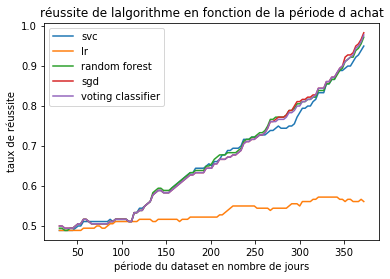

In [47]:
accuracy_score_list = np.array(accuracy_score_list).astype(float) 
labels = ['svc', 'lr','random forest', 'sgd', 'voting classifier']
import matplotlib.pyplot as plt
ax = plt.gca()
for i in range(0,5): 
    ax.plot(index, accuracy_score_list[:,i], label = labels[i])
ax.legend()
plt.xlabel('période du dataset en nombre de jours')
plt.ylabel('taux de réussite')
plt.title('réussite de lalgorithme en fonction de la période d achat')
plt.axis('tight')
plt.show()

On voit que le fait d'avoir choisi des features qui ne vont se modifier que peu dans le temps et qui vont à priori permettre de faire converger notre algorithme à marcher. Au bout de 30 jours, on a déjà un classifieur qui a un taux de réussite de 50%. 

## Taux de réussite des différentes classes au cours du temps

On peut également observer la convergence pour chacune des classes de notre classifieur:

c:\users\zakis\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
c:\users\zakis\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


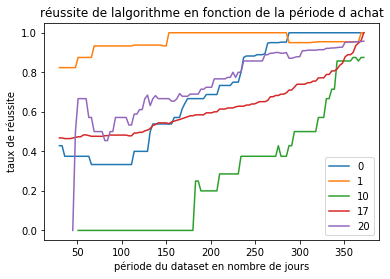

In [54]:
accuracy_score_user_ = []
for i in range(0,len(index)):
    c = confusion_matrixes[i]
    accuracy_score_user_.append([c[0][0]/sum(c)[0],
                                 c[1][1]/sum(c)[1],
                                 c[2][2]/sum(c)[2],
                                 c[3][3]/sum(c)[3],
                                 c[4][4]/sum(c)[4]])
    
accuracy_score_user_ = np.array(accuracy_score_user_).astype(float) 

labels = y_kmeans_class
import matplotlib.pyplot as plt
ax = plt.gca() 
for i in range(0,5): 
    ax.plot(index, accuracy_score_user_[:,i], label = labels[i])
ax.legend()
plt.xlabel('période du dataset en nombre de jours')
plt.ylabel('taux de réussite par classe du voting classifier')
plt.title('réussite de lalgorithme en fonction de la période d achat')
plt.axis('tight')
plt.show()

On voit que c'est la classe numéro 10 qui est la plus difficile à prévoir. On se rappelle qu'ils correspondent aux utilisateurs qui ont dépensé de l'argent sur le sie mais qui ne reviennent pas souvent.

Il serait intéressant de voir l'évolution des caractéristiques de ces utilisateurs au cours du temps. Nous allons prendre un utilisateur de cette classe et observer son évolution au cours de l'année.

In [78]:
np.argwhere(y_test.values == 13)

array([[ 32,   0],
       [ 38,   0],
       [ 64,   0],
       [ 75,   0],
       [ 90,   0],
       [154,   0],
       [167,   0],
       [177,   0]], dtype=int64)

In [81]:
STOP_DATE = dt.datetime(2011,1,1)
user_caracteristic = []
user = []
index = []
indice = 38
while STOP_DATE <  df.InvoiceDate.max():
    
    df_test =  df[df.InvoiceDate < STOP_DATE] 
    X_test = df_test[np.in1d(df_test.CustomerID, customerID_test)]
    X_test_preprocessed = preprocessing_dataset.preprocess_dataset(X_test)
    customerID_test = X_test_preprocessed.index
    y_test = y_kmeans[np.in1d(customerID, customerID_test)]
    X_test_preprocessed = sc_X.transform(X_test_preprocessed)
    
    pred_gvc = gbc.predict(X_test_preprocessed)
    pred_vc2 = vc2.predict(X_test_preprocessed)
    
    index.append(30+(STOP_DATE - dt.datetime(2011,1,1)).days)
    
    user.append(pred_vc2[indice])
    user_caracteristic.append(X_test_preprocessed[indice,:])
    
    STOP_DATE = STOP_DATE + dt.timedelta(days = 30)

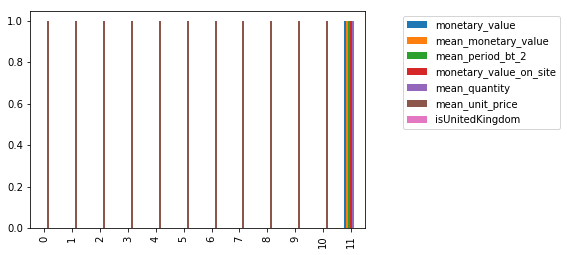

In [82]:
user_caracteristic = np.array(user_caracteristic).reshape((12,len(data.columns)))
mm_sc = MinMaxScaler()
user_caracteristic = mm_sc.fit_transform(user_caracteristic)
user_caracteristic = pd.DataFrame(user_caracteristic, columns = data.columns)
ax = user_caracteristic.plot.bar();
ax.legend(bbox_to_anchor=(1.1, 1))

On voit que cette acheteur n'a pas dépensé d'argent avant le dernier mois ce pourquoi il est impossible de le classifier correctement avant. 

## Conclusion

Nous avons clusteriser nos utilisateurs via un algorithme de k-means qui nous permet de différencier différents types d'utilisateurs. Nous avons essayer de faire apparaitre l'algorithme le plus efficace pour les classifier. nous avons choisi un voting classifier composé d'un random forest, d'un SVC et d'un gradient boosting.

On a donc réussi à classer nos utilisateurs de la manière la plus rapide possible en essayant de ne prendre en compte que les variables qui permettent de classifier les utilisateurs le plus rapidement possible. 

Cependant on voit dans la dernière partie que les utilisateurs nouveaux ont du mal à être classifier. C'est parce que nous avons supprimer les variables tels que recency et frequency (on aurait pu également enregistrer une variable qui nous permettrait de savoir combien de jours se sont passés depuis le premier achat). Nous avons décider de supprimer ces variables pour pouvoir classifier nos utilisateurs le plus rapidement possible. 

Sans être aussi radical dans notre approche, il aurait pu être possible de prendre en compte ces variables mais en leur donnant une importance moindre dans la classification - en les pondérant. De cette manière on aurait pu essayer de faire converger notre algorithme moins rapidement mais en pouvant mieux distinguer les utilisateurs nouveaux des utilisateurs plus anciens.